# Benchmark Evaluation Script

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

[250.]
[500.]


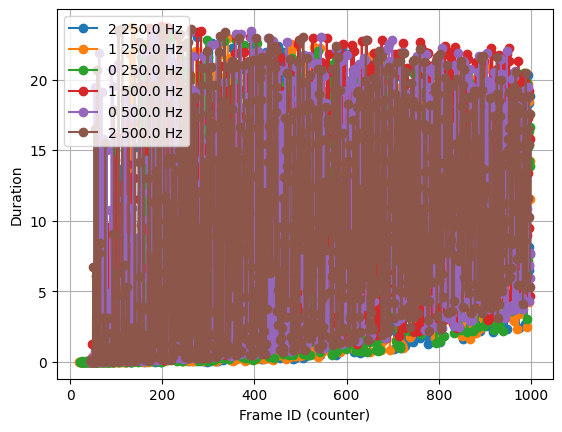

In [2]:
df = pd.read_csv("out/2025-12-22T13:14:20+00:00/data/all_results.csv")


plt.figure()
plt.xlabel('Frame ID (counter)')
plt.ylabel('Duration')
plt.grid()

for frequencies in sorted(df['frequency'].unique()):
    freq_df = df[df['frequency'] == frequencies]
    print(freq_df["frequency"].unique())
    for channel in freq_df['channel'].unique():
        channel_df = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
        plt.plot(channel_df['counter'], channel_df['duration'], marker='o', linestyle='-', label=f'{channel} {frequencies} Hz')

plt.legend()
plt.show()

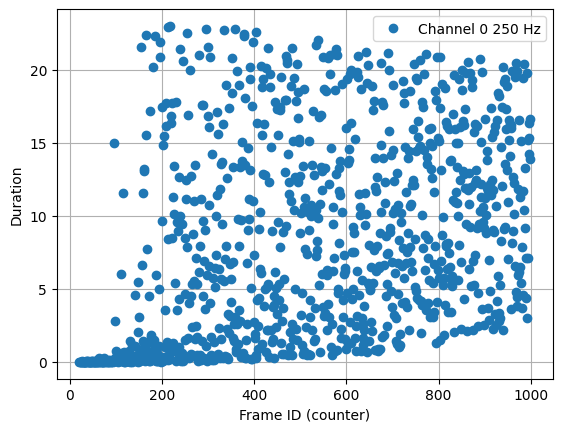

In [3]:
df_f250_channel0 = df[(df['channel'] == 0) & (df['frequency'] == 250.0)]

plt.figure()
plt.xlabel('Frame ID (counter)')
plt.ylabel('Duration')
plt.grid()
plt.plot(df_f250_channel0['counter'], df_f250_channel0['duration'], marker='o', linestyle='', label=f'Channel 0 250 Hz')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Counter Diff vs Receive Time')

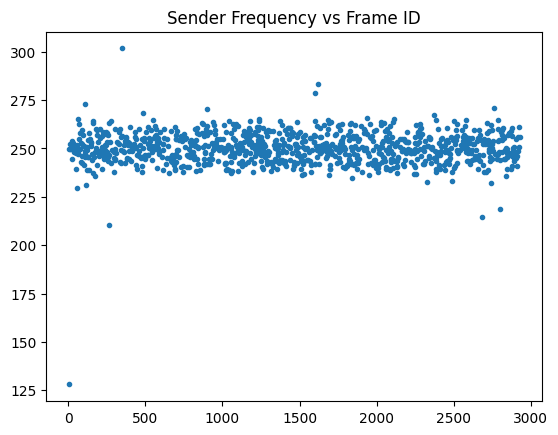

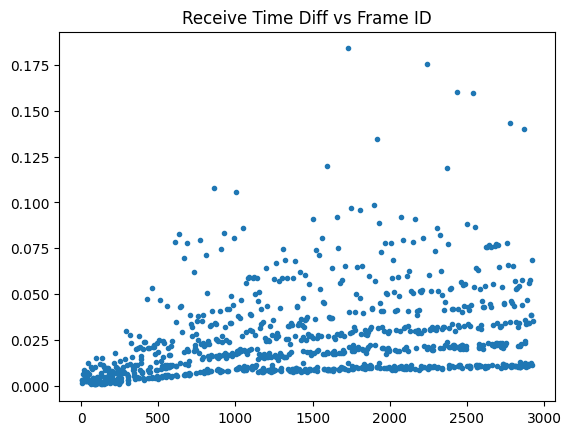

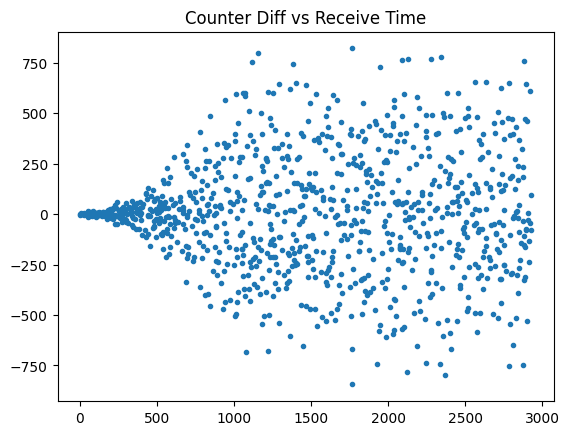

In [21]:
plt.figure()

plt.plot( 1/df_f250_channel0.sort_values("counter")["sender_time"].diff(), marker='o', linestyle='', label=f'Channel 0 250 Hz', markersize=3)
plt.title("Sender Frequency vs Frame ID")

plt.figure()
plt.plot( df_f250_channel0.sort_values("receive_time")["receive_time"].diff(), marker='o', linestyle='', label=f'Channel 0 250 Hz', markersize=3)
plt.title("Receive Time Diff vs Frame ID")

plt.figure()
plt.plot( df_f250_channel0.sort_values("receive_time")["counter"].diff(), marker='o', linestyle='', label=f'Channel 0 250 Hz', markersize=3)
plt.title("Counter Diff vs Receive Time")


In [14]:
# Filter for frequency 500.0
df_500 = df[df['frequency'] == 500.0]

# Compute the average difference between receive_time and sender_time
avg_diff = (df_500['receive_time'] - df_500['sender_time']).mean()
print(f"Average difference (receive_time - sender_time) for frequency 500.0: {avg_diff}")

Average difference (receive_time - sender_time) for frequency 500.0: 9.30721679250898


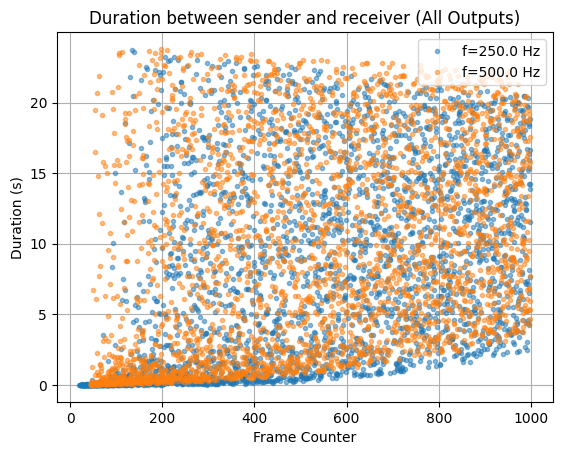

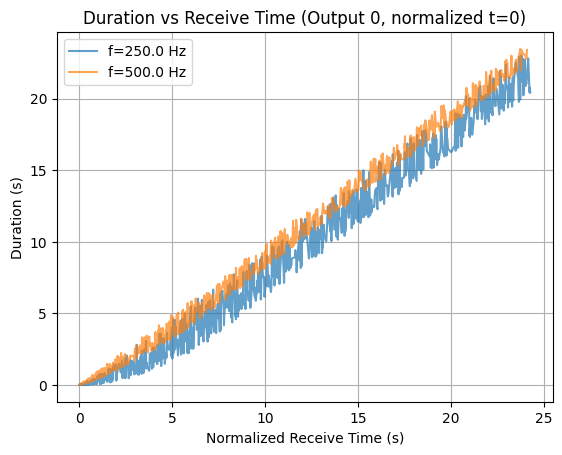

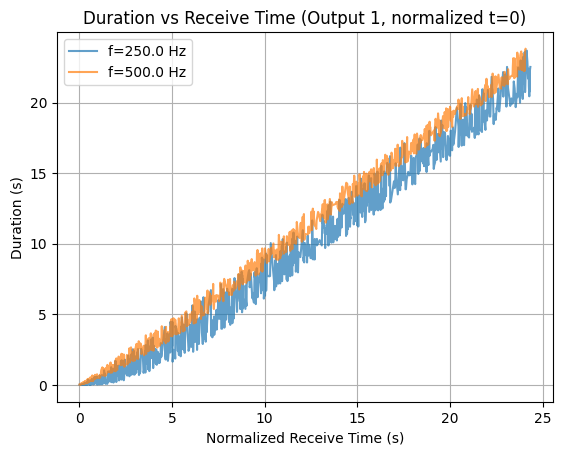

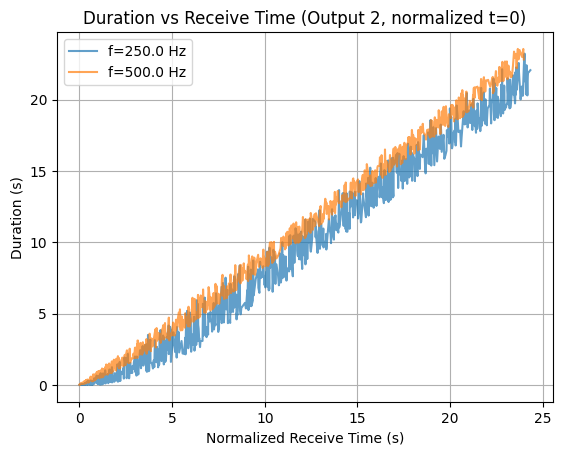

In [16]:
# Plot per output
for channel in sorted(df['channel'].unique()):
    plt.figure()
    output_df = df[df['channel'] == channel]
    for freq in sorted(output_df['frequency'].unique()):
        sub = output_df[output_df['frequency'] == freq]
        plt.plot(sub['counter'], sub['duration'], label=f'f={freq} Hz', alpha=0.7)
    plt.title(f'Duration between sender and receiver (Output {channel})')
    plt.xlabel('Frame Counter')
    plt.ylabel('Duration (s)')
    plt.legend()
    plt.grid()
    plt.close()

# Overall duration plot (all outputs)
plt.figure()
for freq in sorted(df['frequency'].unique()):
    sub = df[df['frequency'] == freq]
    plt.plot(sub['counter'], sub['duration'], '.', label=f'f={freq} Hz', alpha=0.5)
plt.title('Duration between sender and receiver (All Outputs)')
plt.xlabel('Frame Counter')
plt.ylabel('Duration (s)')
plt.legend()
plt.grid()

# New plot: receive time vs duration (normalized so each frequency starts at t=0)
for channel in sorted(df['channel'].unique()):
    plt.figure()
    output_df = df[df['channel'] == channel]
    for freq in sorted(output_df['frequency'].unique()):
        sub = output_df[output_df['frequency'] == freq].copy()
        sub['norm_receive_time'] = sub['receive_time'] - sub['receive_time'].iloc[0]
        plt.plot(sub['norm_receive_time'], sub['duration'], label=f'f={freq} Hz', alpha=0.7)
    plt.title(f'Duration vs Receive Time (Output {channel}, normalized t=0)')
    plt.xlabel('Normalized Receive Time (s)')
    plt.ylabel('Duration (s)')
    plt.legend()
    plt.grid()